In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
import geopandas as gpd
from verification.val_db import (get_finalized_validation_datasets,
                                 read_validation_dataset,
                                 get_val_s3_path
                                )

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import numpy as np
from tqdm import tqdm
import rasterio
from matplotlib.colors import ListedColormap
from shapely.geometry import box
from rasterio.plot import show
from pathlib import Path
from verification.rio_tools import get_geopandas_features_from_array
import pandas as pd
import sklearn.metrics
import json
from verification.hls import get_hls_urls

This index is just relative to the finalized datasets.

In [50]:
PLANET_ID = '20210912_034049_22_2421'#'20211002_155415_1009'
EQUAL_SAMPLING = True
TOTAL_SAMPLES = 500

# Table of Finalized Data

In [51]:
df = get_finalized_validation_datasets()
df.head()

,bucket,calc_type,calculated_by,image_calc_name,image_name,notes,oversight_level,previous_name,processing_level,public,reviewed_by,s3_keys,upload_date,version,water_strata,water_stratum,geometry
0,opera-calval-database-dswx,Review,Charlie Marshak,20210903_150800_60_2458_classification_v2,20210903_150800_60_2458,Previous(Previous((CM): Used a NDWI threshold ...,None,20210903_150800_60_2458_classification_v1,Final,True,Alexander Handwerger,data/site/4_21/image/20210903_150800_60_2458/i...,20220930_152559,2.0,NaN,3.0,"POLYGON ((-71.87051 55.11002, -71.87051 55.166..."
1,opera-calval-database-dswx,Review,Charlie Marshak,20210903_152641_60_105c_classification_v2,20210903_152641_60_105c,Previous(This is water with lots of boalders p...,None,20210903_152641_60_105c_classification_v1.0,Final,True,Matthew Bonnema,data/site/4_11/image/20210903_152641_60_105c/i...,20221019_151359,2.0,NaN,3.0,"POLYGON ((-69.17307 54.40592, -69.17307 54.460..."
2,opera-calval-database-dswx,Review,Matthew Bonnema,20210904_093422_44_1065_classification_v1,20210904_093422_44_1065,Previous(Only water is a small pond near cente...,None,20210904_093422_44_1065_classification_v0,Final,True,Simran Sangha,data/site/1_31/image/20210904_093422_44_1065/i...,20221028_164450,1.0,NaN,1.0,"POLYGON ((17.28244 -29.97141, 17.28244 -29.916..."
3,opera-calval-database-dswx,Review,Alexander Handwerger,20210906_101112_28_225a_classification_v1,20210906_101112_28_225a,Previous(Supervised Classification using Semia...,None,20210906_101112_28_225a_classification_v0,Final,True,Charlie Marshak,data/site/3_28/image/20210906_101112_28_225a/i...,20220929_144718,1.0,NaN,2.0,"POLYGON ((-0.04389 43.05233, -0.04389 43.16776..."
4,opera-calval-database-dswx,Review,Charlie Marshak,20210909_000649_94_222b_classification_v1,20210909_000649_94_222b,Previous((CM): Looked at RGB and false color b...,None,20210909_000649_94_222b_classification_v0,Final,True,Alexander Handwerger,data/site/1_37/image/20210909_000649_94_222b/i...,20221027_162451,1.0,NaN,1.0,"POLYGON ((138.25959 -30.32811, 138.25959 -30.2..."


In [52]:
f'Currently, there are {df.shape[0]} finalized datasets'

'Currently, there are 52 finalized datasets'

# Read a Validation Dataset

In [53]:
X_val, p_val = read_validation_dataset(PLANET_ID)
p_val

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 2001, 'height': 2001, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(3.0, 0.0, 391161.0,
       0.0, -3.0, 5473992.0), 'blockysize': 4, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

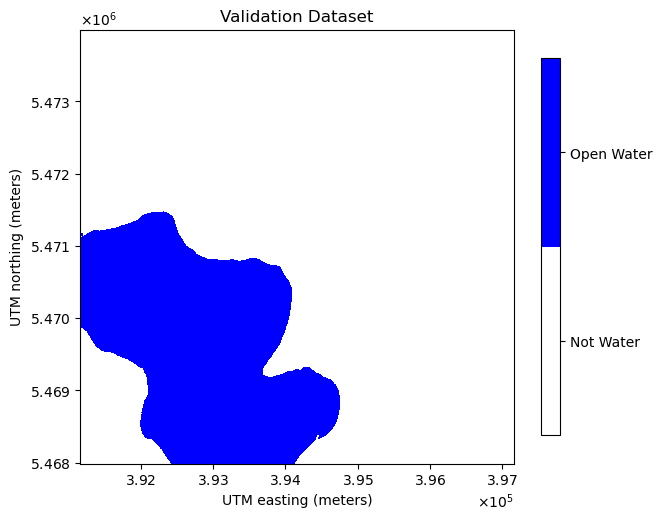

In [54]:
Y = X_val.astype(float)
Y[Y == 255] = np.nan

fontSize=10
fig, ax=plt.subplots(figsize=(7,7))
cmap = ListedColormap(['white', 'blue'])
im=ax.imshow(Y, interpolation='none',cmap=cmap,vmin=0,vmax=1)
show(Y, interpolation='none',cmap=cmap,vmin=0,vmax=1,transform=p_val['transform'],ax=ax)
cbar = fig.colorbar(im, ax=ax,shrink=0.7,ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Not Water', 'Open Water']);  # vertically oriented colorbar
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)
plt.xticks(fontsize = fontSize)
plt.yticks(fontsize = fontSize)
ax.set_title('Validation Dataset');
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)

# Load Local Validation Table

In [55]:
df_validation_table = pd.read_csv('validation_table_data.csv')
df_validation_table.head()

,planet_id,hls_id,dswx_urls
0,20210903_150800_60_2458,HLS.L30.T18UXG.2021245T154154.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
1,20210903_152641_60_105c,HLS.S30.T19UDA.2021245T154911.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
2,20210904_093422_44_1065,HLS.S30.T33JYG.2021248T082559.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
3,20210906_101112_28_225a,HLS.S30.T30TYN.2021248T105621.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
4,20210909_000649_94_222b,HLS.L30.T54JTM.2021251T003848.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...


# Get Associated HLS Id

In [56]:
HLS_ID = df_validation_table[df_validation_table.planet_id == PLANET_ID].hls_id.iloc[0]
HLS_ID

'HLS.S30.T47ULQ.2021254T043701.v2.0'

# Get DSWx Products

In [57]:
dswx_urls = df_validation_table[df_validation_table.planet_id == PLANET_ID].dswx_urls.iloc[0].split(',')
dswx_urls

['https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0_B01_WTR.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0_B02_BWTR.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0_B03_CONF.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0_B04_DIAG.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_2022102

In [58]:
with rasterio.open(dswx_urls[0]) as ds:
    X_dswx = ds.read(1)
    p_dswx = ds.profile
    crs_dswx = ds.crs
    colormap = ds.colormap(1)
    dswx_crs = ds.crs

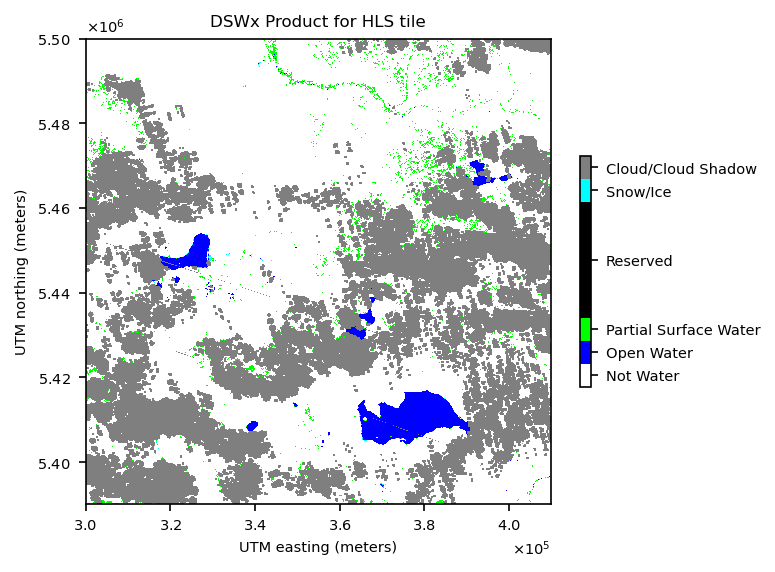

In [59]:
fontSize=7
fontSizeTitle=8
fig, ax = plt.subplots(dpi=150,figsize=(5,5))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
im_dswx=ax.imshow(X_dswx, interpolation='none',cmap=cmap,vmin=0,vmax=255)
show(X_dswx, interpolation='none',cmap=cmap,vmin=0,vmax=255,transform=p_dswx['transform'],ax=ax)
cbar=fig.colorbar(im_dswx,ax=ax,shrink=0.4,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],fontsize=fontSize)   
cbar.ax.set_ylim(0,10)
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)
plt.xticks(fontsize = fontSize)
plt.yticks(fontsize = fontSize)
ax.set_title('DSWx Product for HLS tile',fontsize=fontSizeTitle);
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)

# Compare Extents

Inspect the DSWx Subset and it's corresponding Validation Dataset

In [60]:
val_url = get_val_s3_path(PLANET_ID)
with rasterio.open(val_url) as ds:
    val_bounds = list(ds.bounds)
    val_crs = ds.crs

The two datasets are frequently in the same CRS. Just in case, we reproject to DSWx projection.

In [61]:
df_val_bounds = gpd.GeoDataFrame(geometry=[box(*val_bounds).buffer(60)],
                                 crs=val_crs)
df_val_bounds = df_val_bounds.to_crs(dswx_crs)
df_val_bounds

,geometry
0,"POLYGON ((397164.000 5467929.000, 391161.000 5..."


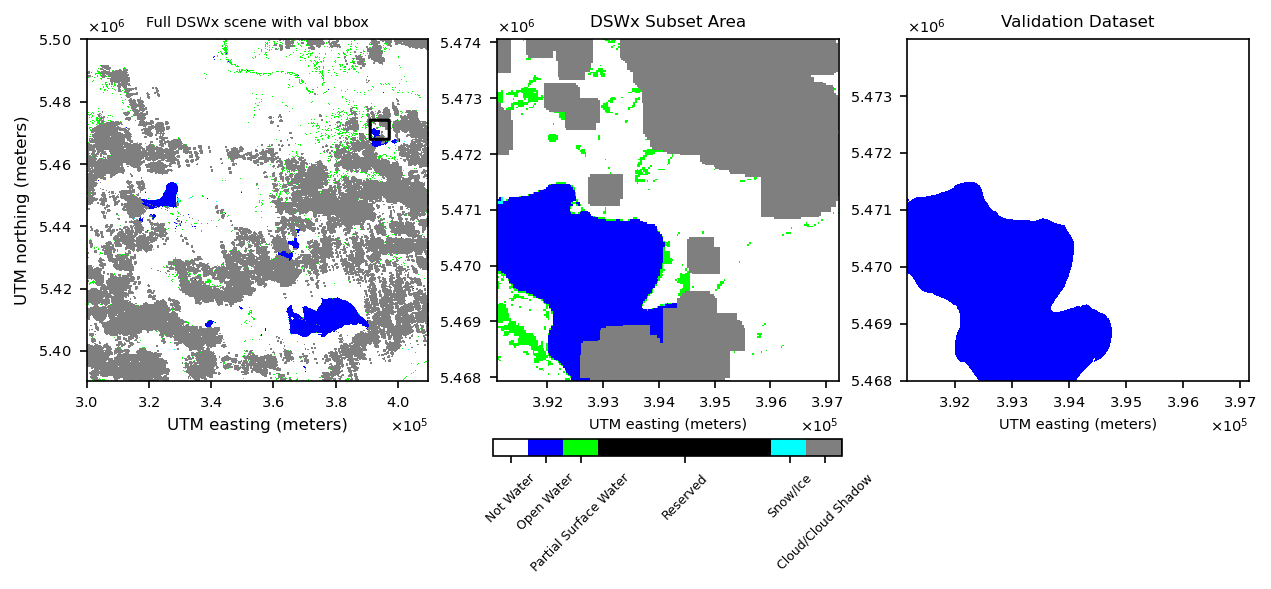

In [62]:
fontSize=7
fontSizeTitles=8
fig, ax = plt.subplots(1, 3, dpi=150, figsize=(10, 10))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])

show(X_dswx, cmap=cmap, transform=p_dswx['transform'], vmin=0, vmax=255, interpolation='none', ax=ax[0])
df_val_bounds.to_crs(crs_dswx).boundary.plot(ax=ax[0], color='black')
ax[0].set_title('Full DSWx scene with val bbox',fontsize=fontSize)
ax[0].set_xlabel('UTM easting (meters)',fontsize=fontSizeTitles)
ax[0].set_ylabel('UTM northing (meters)',fontsize=fontSizeTitles)
ax[0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[0].tick_params(axis='both', which='major', labelsize=fontSize)
ax[0].yaxis.get_offset_text().set_fontsize(fontSize)
ax[0].xaxis.get_offset_text().set_fontsize(fontSize)

show(X_dswx, cmap=cmap, transform=p_dswx['transform'], vmin=0,vmax=255, interpolation='none', ax=ax[1])
val_bounds_dswx = df_val_bounds.to_crs(crs_dswx).total_bounds
ax[1].set_xlim(val_bounds_dswx[0], val_bounds_dswx[2])
ax[1].set_ylim(val_bounds_dswx[1], val_bounds_dswx[3])
ax[1].set_title('DSWx Subset Area',fontsize=fontSizeTitles)
ax[1].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[1].tick_params(axis='both', which='major', labelsize=fontSize)
ax[1].yaxis.get_offset_text().set_fontsize(fontSize)
ax[1].xaxis.get_offset_text().set_fontsize(fontSize)

show(X_val, transform=p_val['transform'], ax=ax[2], interpolation='none', cmap=cmap, vmin=0, vmax=255)
ax[2].set_title('Validation Dataset',fontsize=fontSizeTitles)
ax[2].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[2].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[2].tick_params(axis='both', which='major', labelsize=fontSize)
ax[2].yaxis.get_offset_text().set_fontsize(fontSize)
ax[2].xaxis.get_offset_text().set_fontsize(fontSize)

cbar=fig.colorbar(im_dswx,ax=ax,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5],shrink=0.3,orientation='horizontal',fraction=0.32,pad=.05)
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],rotation=45)   
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_xlim(0,10);

# Crop Datasets

In [63]:
from dem_stitcher.rio_window import read_raster_from_window

In [64]:
X_dswx_c, p_dswx_c = read_raster_from_window(dswx_urls[0], 
                                             list(df_val_bounds.total_bounds), 
                                             df_val_bounds.crs)

# Resample Validation Dataset to DSWx Product

This extracts a percent open surface water in HLS frame.

In [65]:
from dem_stitcher.rio_tools import reproject_arr_to_match_profile, update_profile_resolution

X_val_temp = X_val.astype('float32')
X_val_temp[(X_val == 10) | (X_val == 255)] = np.nan

p_val_temp = p_val.copy()
p_val_temp['dtype'] = 'float32'
p_val_temp['nodata'] = np.nan

p_dswx_c_mod = update_profile_resolution(p_dswx_c, 
                                         p_val['transform'].a)


X_val_per_w_int, p_per_int = reproject_arr_to_match_profile(X_val_temp,
                                                    p_val_temp, 
                                                    p_dswx_c_mod)
X_val_per_w_int = X_val_per_w_int[0, ...]

X_val_per_w, _ = reproject_arr_to_match_profile(X_val_per_w_int,
                                                p_per_int, 
                                                p_dswx_c)
X_val_per_w = X_val_per_w[0, ...]

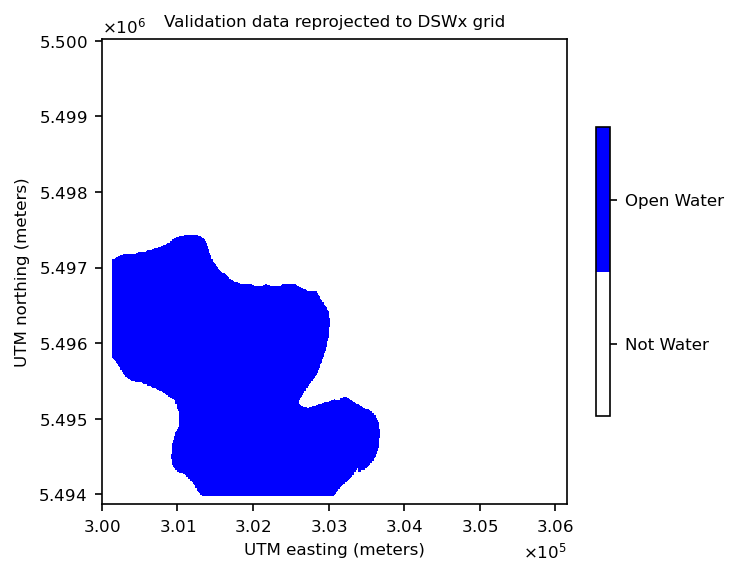

In [66]:
fontSize=8
fig, ax = plt.subplots(dpi=150,figsize=(5, 5))
# cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
cmap = ListedColormap(['white', 'blue'])
im=ax.imshow(X_val_per_w, interpolation='none',cmap=cmap,vmin=np.nanmin(X_val_per_w),vmax=np.nanmax(X_val_per_w))
show(X_val_per_w, vmin=np.nanmin(X_val_per_w),vmax=np.nanmax(X_val_per_w), transform=p_dswx['transform'], ax=ax,cmap=cmap)
cbar=fig.colorbar(im,ax=ax,shrink=0.5,ticks=[0.25, 0.75])
cbar.set_ticklabels(['Not Water', 'Open Water'],fontsize=fontSize)   
cbar.ax.set_ylim(np.nanmin(X_val_per_w),np.nanmax(X_val_per_w))
ax.set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax.set_ylabel('UTM northing (meters)',fontsize=fontSize)
plt.title('Validation data reprojected to DSWx grid',fontsize=fontSize)
plt.xticks(fontsize = fontSize)
plt.yticks(fontsize = fontSize);
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)

Convert to DSWx Labels.

In [67]:
X_val_r = np.full(X_val_per_w.shape, 255)

mask = np.isnan(X_val_per_w)

ind_w = (X_val_per_w == 1)
X_val_r[ind_w] = 1

ind_pw = (X_val_per_w >= .5) & (X_val_per_w < 1)
X_val_r[ind_pw] = 2

ind_nw = (X_val_per_w < .5)
X_val_r[ind_nw] = 0

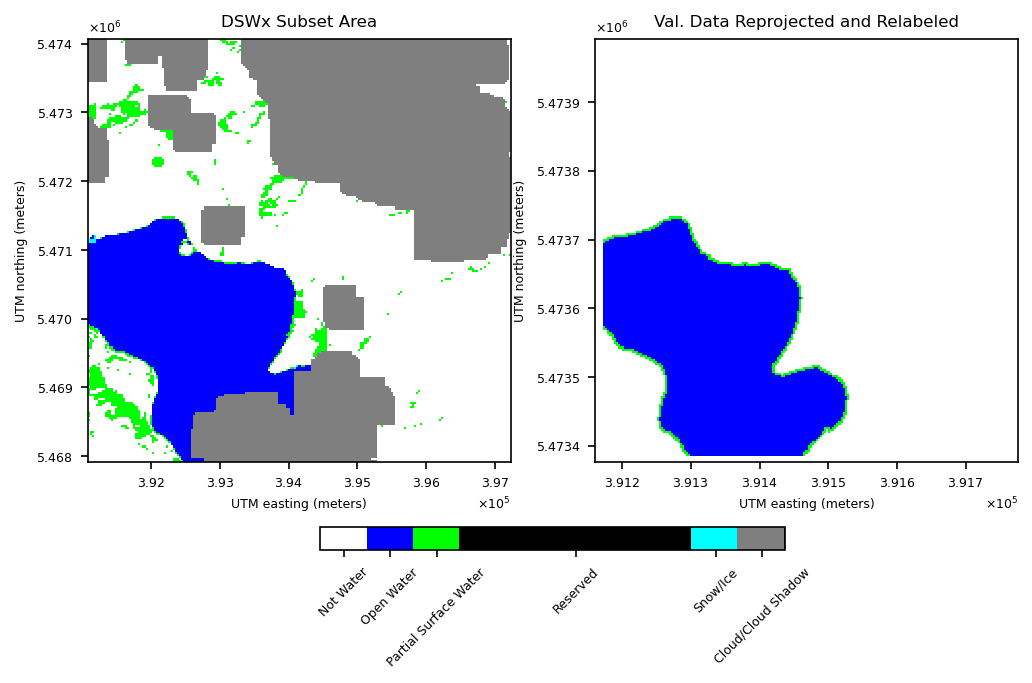

In [68]:
fontSize=6
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(8, 8))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
im=ax[0].imshow(X_dswx_c, interpolation='none',cmap=cmap,vmin=0,vmax=255)

show(X_dswx_c, cmap=cmap, transform=p_dswx_c['transform'], interpolation='none', ax=ax[0], vmin=0,vmax=255)
ax[0].set_title('DSWx Subset Area',fontsize=8)
ax[0].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[0].set_ylabel('UTM northing (meters)',fontsize=fontSize)
ax[0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[0].tick_params(axis='both', which='major', labelsize=fontSize)
ax[0].yaxis.get_offset_text().set_fontsize(fontSize)
ax[0].xaxis.get_offset_text().set_fontsize(fontSize)

show(X_val_r, cmap=cmap, transform=p_val['transform'], interpolation='none',ax=ax[1], vmin=0, vmax=255)
ax[1].set_title('Val. Data Reprojected and Relabeled',fontsize=8)
ax[1].set_xlabel('UTM easting (meters)',fontsize=fontSize)
ax[1].set_ylabel('UTM northing (meters)',fontsize=fontSize)

ax[1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax[1].tick_params(axis='both', which='major', labelsize=fontSize)
ax[1].yaxis.get_offset_text().set_fontsize(fontSize)
ax[1].xaxis.get_offset_text().set_fontsize(fontSize)

cbar=fig.colorbar(im,ax=ax,ticks=[0.5, 1.5,2.5,5.5,8.5,9.5],shrink=0.5,orientation='horizontal',pad=.071)
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],rotation=45)   
cbar.ax.tick_params(labelsize=fontSize)
cbar.ax.set_xlim(0,10);

**Warning**: In many cases, the UTM zone of the validation dataset and the OPERA DSWx product do not match. So despite some of the side-by-side plots that appear parallel, the rotation above can come as surprise. A slight rotation will occur if the below CRS's are different.

In [69]:
print('DSWx CRS: ', p_dswx['crs'])
print('Validation CRS: ', p_val['crs'])

DSWx CRS:  PROJCS["UTM Zone 47, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not_specified_based_on_WGS_84_spheroid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Validation CRS:  EPSG:32647


# Save Relevant Rasters for Inspection

In [70]:
dswx_urls[0].split('_B01')[0]

'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0'

In [71]:
DSWx_ID = dswx_urls[0].split('_B01')[0].split('/')[-1]
DSWx_ID

'OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20221026T043506Z_S2A_30_v0.0'

In [72]:
out_dir = Path('verification_assessment_data') / DSWx_ID
out_dir.mkdir(exist_ok=True, parents=True)

In [73]:
p_val_r = p_dswx_c.copy()
p_val_r['dtype'] = np.uint8
p_val_r['nodata'] = 255

with rasterio.open(out_dir / f'validation_r_{DSWx_ID}.tif', 'w', **p_val_r) as ds:
    ds.write(X_val_r, 1)
    ds.write_colormap(1, colormap)

In [74]:
p_perc_r = p_dswx_c.copy()
p_perc_r['dtype'] = np.float32
p_perc_r['nodata'] = np.nan

with rasterio.open(out_dir / f'percent_r_{DSWx_ID}.tif', 'w', **p_perc_r) as ds:
    ds.write(X_val_per_w, 1)

In [75]:
with rasterio.open(out_dir / f'percent_intermediate_{DSWx_ID}.tif', 'w', **p_per_int) as ds:
    ds.write(X_val_per_w_int, 1)

In [76]:
with rasterio.open(out_dir / f'{DSWx_ID}.tif', 'w', **p_dswx_c) as ds:
    ds.write(X_dswx_c, 1)
    ds.write_colormap(1, colormap)

In [77]:
with rasterio.open(out_dir / f'validation_original_{DSWx_ID}.tif', 'w', **p_val) as ds:
    ds.write(X_val, 1)
    ds.write_colormap(1, colormap)

# Scene-wise stratified sampling

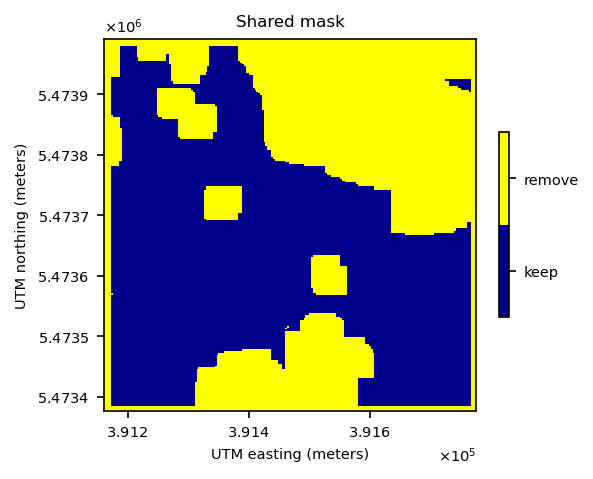

In [78]:
shared_mask = (X_val_r == 255) | ~(np.isin(X_dswx_c, [0, 1, 2]))

fontSize=7
fig, ax = plt.subplots(dpi=150,figsize=(4, 4))
cmap = ListedColormap(['darkblue', 'yellow'])
im=ax.imshow(shared_mask, interpolation='none',cmap=cmap,vmin=np.nanmin(shared_mask),vmax=np.nanmax(shared_mask))
show(shared_mask, transform=p_val['transform'], interpolation='none', vmin=np.nanmin(shared_mask),vmax=np.nanmax(shared_mask),ax=ax,cmap=cmap)  
cbar=fig.colorbar(im,ax=ax,shrink=0.4,ticks=[0.25, .75])
cbar.set_ticklabels(['keep', 'remove'],fontsize=fontSize)   
cbar.ax.set_ylim(0,1)
ax.set_title('Shared mask',fontsize=8);
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.xticks(fontsize=fontSize);

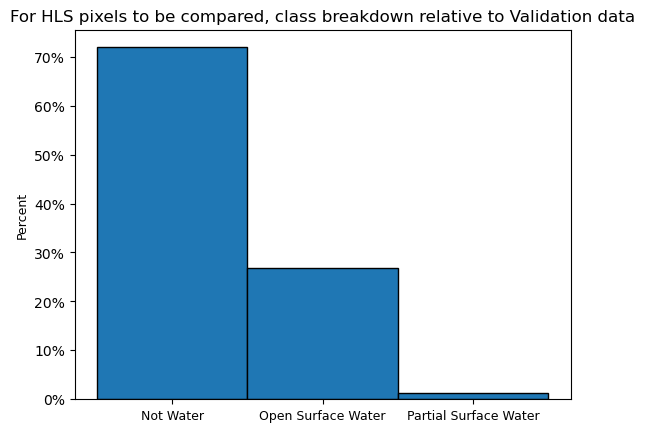

In [79]:
percents, _, _ = plt.hist(X_val_r[~shared_mask], bins=3, range=(0, 3), density=True, edgecolor='black')
plt.xticks(np.arange(0, 3)+.5, ['Not Water', 'Open Surface Water', 'Partial Surface Water'],fontsize=9)
plt.ylabel('Percent',fontsize=9)
plt.title('For HLS pixels to be compared, class breakdown relative to Validation data');
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

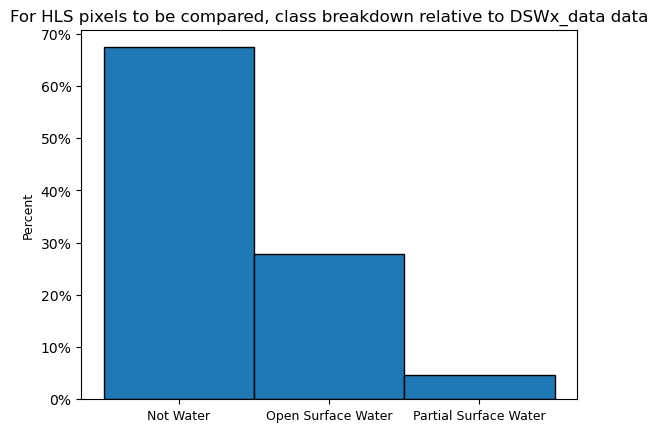

In [80]:
percents_dswx, _, _ = plt.hist(X_dswx_c[~shared_mask], bins=3, range=(0, 3), density=True, edgecolor='black')
plt.xticks(np.arange(0, 3)+.5, ['Not Water', 'Open Surface Water', 'Partial Surface Water'],fontsize=9)
plt.ylabel('Percent',fontsize=9)
plt.title('For HLS pixels to be compared, class breakdown relative to DSWx_data data');
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [81]:
percents_dswx

array([0.67402808, 0.27909496, 0.04687695])

In [82]:
plt.close('all')

In [83]:

sample_size_per_label = [int(np.ceil(percents[label] * TOTAL_SAMPLES)) for label in [0, 1, 2]]
if EQUAL_SAMPLING:
    present_classes = (percents_dswx > 0).sum()
    sample_size_per_label = [int(np.ceil(TOTAL_SAMPLES / present_classes))] * 3  #always multiply by 3 because we have 3 labe;s

In [84]:
np.random.seed(0)
# list of lists, 
# each index corresponds to class label 0, 1, 2 and the list will contain
# indices within the flattend array of that label
stratified_selection = [] 
validation_hls_pixels = X_val_r[~shared_mask]
dswx_hls_pixels = X_dswx_c[~shared_mask]

for label in [0, 1, 2]:
    # Sampling from PRODUCT PIXELS now
    indices = np.argwhere(dswx_hls_pixels == label).ravel()
    
    # See if there are enough samples otherwise select the total number of samples available
    subset_size = sample_size_per_label[label]
    subset_size = np.minimum(subset_size, len(indices))
    sample_size_per_label[label] = subset_size
    
    indices_subset = np.random.choice(indices, subset_size, replace=False)
    stratified_selection.append(indices_subset)
sample_size_per_label

[167, 167, 167]

In [85]:
validation_labels = [label for label in [0, 1, 2] for k in range(len(stratified_selection[label]))]
opera_dswx_labels = [dswx_label 
                     for label in [0, 1, 2] 
                     for dswx_label in dswx_hls_pixels[stratified_selection[label]]]
len(validation_labels), len(opera_dswx_labels)

(501, 501)

In [86]:
X_samples = np.full(shared_mask.shape, 0)
temp = X_samples[~shared_mask]

k = 1

sample2validation = {}
sample2dswx = {}

for label in [0, 1, 2]:
    for ind in stratified_selection[label]:
        temp[ind] = k
        # ensure we can look up the sample id and find the correct label for the different datasets we compare
        sample2validation[k] = label
        sample2dswx[k] = dswx_hls_pixels[ind]
        k += 1
    
X_samples[~shared_mask] = temp
(X_samples > 0).sum()

501

In [87]:
features = get_geopandas_features_from_array(# Note 8 bits is not enough for 500 points
                                             X_samples.astype(np.int32), 
                                             transform=p_dswx_c['transform'],
                                             mask=(X_samples==0),
                                             label_name='sample_id'
                                            )
df_samples = gpd.GeoDataFrame.from_features(features, 
                                            crs=p_dswx_c['crs'])
df_samples['val_label'] = df_samples['sample_id'].map(lambda label: sample2validation[label])
df_samples['dswx_label'] = df_samples['sample_id'].map(lambda label: sample2dswx[label])

df_samples.head()

,geometry,sample_id,val_label,dswx_label
0,"POLYGON ((393090.000 5473950.000, 393090.000 5...",152.0,0,0
1,"POLYGON ((393060.000 5473800.000, 393060.000 5...",11.0,0,0
2,"POLYGON ((391770.000 5473680.000, 391770.000 5...",2.0,0,0
3,"POLYGON ((393180.000 5473620.000, 393180.000 5...",40.0,0,0
4,"POLYGON ((393060.000 5473590.000, 393060.000 5...",102.0,0,0


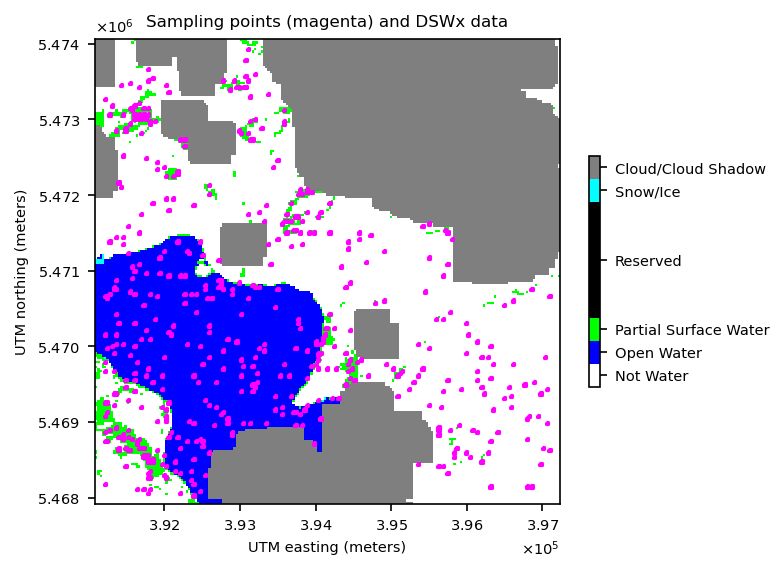

In [88]:
fontSize=7
fontSizeTitle=8
fig, ax = plt.subplots(dpi=150,figsize=(5,5))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
show(X_dswx_c,cmap=cmap,transform=p_dswx_c['transform'],interpolation='none',ax=ax,vmin=0,vmax=255)
df_samples.to_crs(p_dswx_c['crs']).boundary.plot(ax=ax, color='magenta',alpha=1)
ax.set_title('Sampling points (magenta) and DSWx data',fontsize=fontSizeTitle)
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)
cbar=fig.colorbar(im_dswx,ax=ax,shrink=0.4,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],fontsize=fontSize)   
cbar.ax.set_ylim(0,10);
ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)
plt.yticks(fontsize=fontSize)
plt.xticks(fontsize=fontSize);

In [89]:
with rasterio.open(out_dir / f'samples_{DSWx_ID}.tif', 'w', **p_dswx_c) as ds:
    ds.write(X_samples, 1)

In [90]:
df_samples.to_file(out_dir / f'samples_{DSWx_ID}')

# Accuracy Assessment

In [91]:
class_dict = {0: 'Not_Water',
              1: 'Open_Surface_Water', 
              2: 'Partial_Surface_Water'}
Target_Names=['Not_Water','Open_Surface_Water','Partial_Surface_Water']

y_val = validation_hls_pixels
y_dswx = dswx_hls_pixels

## comment to inspect all pixels
y_val = np.array([label for ind in stratified_selection for label in validation_hls_pixels[ind]])
y_dswx = np.array([label  for ind in stratified_selection for label in dswx_hls_pixels[ind]])

## Total Accuracy

In [92]:
# total_acc=(y_dswx == y_val).sum()/y_val.size
total_acc=sklearn.metrics.accuracy_score(y_val, y_dswx)
print('Total Accuracy = ', total_acc*100 ,'%')

Total Accuracy =  64.27145708582835 %


## Confusion Matrix

In [93]:
y_dswx_str = pd.Series([class_dict[class_id] for class_id in y_dswx], name='OPERA_DSWx')
y_val_str = pd.Series([class_dict[class_id] for class_id in y_val], name='OPERA_Validation')
df_conf = pd.crosstab(y_val_str, y_dswx_str)
df_conf

OPERA_DSWx,Not_Water,Open_Surface_Water,Partial_Surface_Water
OPERA_Validation,,,
Not_Water,167,1,165
Open_Surface_Water,0,153,0
Partial_Surface_Water,0,13,2


In [94]:
df_conf_formatted = df_conf.astype(int)
name = df_conf.index.name
df_conf_formatted.rename(index={index: f'{index}_{name}' for index in df_conf.index}, inplace=True)
col_name = df_conf.columns.name
df_conf_formatted.rename(columns={col: f'{col}_{col_name}' for col in df_conf.columns}, inplace=True)
df_conf_formatted.to_dict();

## Classification Report

In [95]:
prec, recall, f1, supp = sklearn.metrics.precision_recall_fscore_support(y_val, y_dswx, labels=[0, 1, 2])
recall_per_class = {class_dict[label]: recall[label] for label in [0, 1, 2]}
prec_per_class = {class_dict[label]: prec[label] for label in [0, 1, 2]}
f1_per_class = {class_dict[label]: f1[label] for label in [0, 1, 2]}
supp_per_class = {class_dict[label]: int(supp[label]) for label in [0, 1, 2]}

In [96]:
Class_Report = sklearn.metrics.classification_report(y_val, y_dswx, labels=[0, 1, 2], target_names=Target_Names)
print(Class_Report)

                       precision    recall  f1-score   support

            Not_Water       1.00      0.50      0.67       333
   Open_Surface_Water       0.92      1.00      0.96       153
Partial_Surface_Water       0.01      0.13      0.02        15

             accuracy                           0.64       501
            macro avg       0.64      0.54      0.55       501
         weighted avg       0.94      0.64      0.74       501



## Accuracy per class

In [97]:
acc_per_class = {}

for c in [0, 1, 2]:
    y_val_temp = y_val.copy()
    y_dswx_temp = y_dswx.copy()
    
    y_val_temp[y_val_temp != c] = 255
    y_dswx_temp[y_dswx_temp != c] = 255

    acc_per_class[class_dict[c]] = (y_val_temp == y_dswx_temp).sum() / y_dswx.size

acc_per_class

{'Not_Water': 0.6686626746506986,
 'Open_Surface_Water': 0.9720558882235529,
 'Partial_Surface_Water': 0.6447105788423154}

## Serialize

In [98]:
assessment = {'dswx_id': DSWx_ID,
              'precision': prec_per_class,
              'recall': recall_per_class,
              'f1_per_class': f1_per_class,
              'supp_per_class':supp_per_class,
              'confusion_matrix': df_conf_formatted.to_dict(),
              'accuracy_per_class': acc_per_class}

json.dump(assessment, open(out_dir / f'assessment_{DSWx_ID}.json', 'w'))

In [99]:
df_conf.to_csv(out_dir / f'confusion_matrix_{DSWx_ID}.csv')

# Verify Requirements

In [100]:
open_surface_water_req = False
if assessment['accuracy_per_class']['Open_Surface_Water'] >= .80:
    open_surface_water_req = True

In [101]:
partial_surface_water_req = False
if assessment['accuracy_per_class']['Partial_Surface_Water'] >= .70:
    partial_surface_water_req = True

In [102]:
print(f'Passed Open Surface Water Requirement: ', open_surface_water_req)
print(f'Passed Partial Surface Water Requirement: ', partial_surface_water_req)

Passed Open Surface Water Requirement:  True
Passed Partial Surface Water Requirement:  False


In [103]:
hls_urls_dict = get_hls_urls(HLS_ID)

In [104]:
dswx_urls_dict = {f'dswx-{url.split(".")[-2][6:]}': url 
                  for url in dswx_urls}

In [105]:
requirement_verification = {'dswx_id': DSWx_ID,
                            'surface_water': open_surface_water_req,
                            'partial_surface_water': partial_surface_water_req,
                            **dswx_urls_dict,
                            'planet_id': PLANET_ID,
                            'validation_dataset_s3': get_val_s3_path(PLANET_ID),
                            'hls_id': HLS_ID,
                            **hls_urls_dict}

json.dump(requirement_verification, open(out_dir / f'requirement_verification_{DSWx_ID}.json', 'w'))

Lastly, calculate differance map to show where DSWx and Validation data agree/disagree

In [106]:
X_diff_temp=X_dswx_c-X_val_r
X_diff=X_diff_temp

X_diff=X_diff_temp.astype('float32')
X_diff[(X_diff_temp < -5) | (X_diff_temp > 5)] = np.nan

print(["min = "  + str(np.nanmin(X_diff)), "max = " + str(np.nanmax(X_diff))])

['min = -2.0', 'max = 2.0']


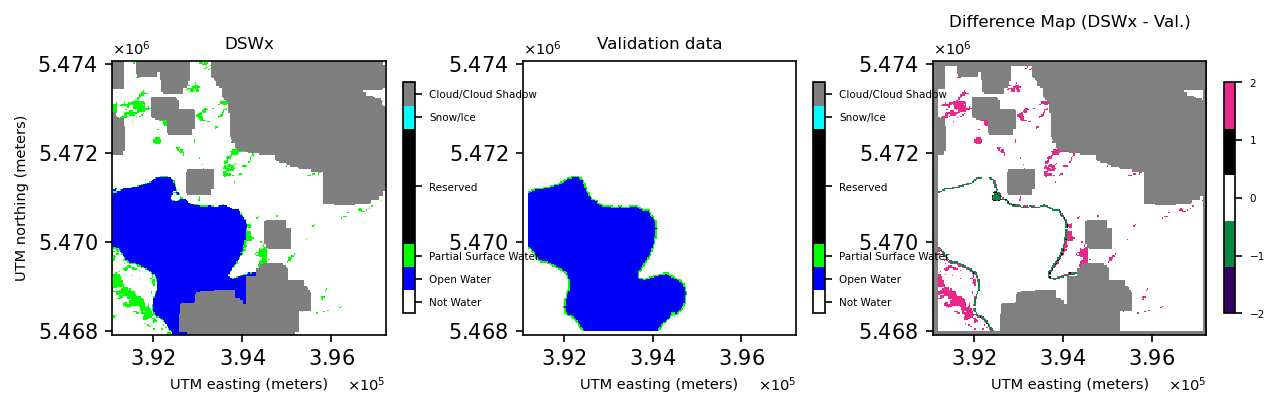

In [107]:
fontSize=7
fontSizeTitle=8
fig, axs = plt.subplots(1, 3, dpi=150, figsize=(10, 10))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])

im0 = axs[0].imshow(X_dswx_c, cmap=cmap, vmin=0, interpolation='none', vmax=255)
show(X_dswx_c, interpolation='none',cmap=cmap,vmin=0,vmax=255,transform=p_dswx_c['transform'],ax=axs[0])
axs[0].set_title('DSWx',fontsize=fontSizeTitle)
axs[0].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
axs[0].set_xlabel('UTM easting (meters)',fontsize=fontSize)
axs[0].set_ylabel('UTM northing (meters)',fontsize=fontSize)
axs[0].yaxis.get_offset_text().set_fontsize(fontSize)
axs[0].xaxis.get_offset_text().set_fontsize(fontSize)
cbar=fig.colorbar(im0,ax=axs[0],shrink=0.2,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],fontsize=5,rotation=0)   
cbar.ax.set_ylim(0,10)
cbar.ax.tick_params(labelsize=5)

im1 = axs[1].imshow(X_val_r, cmap=cmap, vmin=0, interpolation='none', vmax=255)
show(X_val_r, interpolation='none',cmap=cmap,vmin=0,vmax=255,transform=p_val_r['transform'],ax=axs[1])
axs[1].set_title('Validation data',fontsize=fontSizeTitle)
axs[1].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
axs[1].set_xlabel('UTM easting (meters)',fontsize=fontSize)
axs[1].yaxis.get_offset_text().set_fontsize(fontSize)
axs[1].xaxis.get_offset_text().set_fontsize(fontSize)
cbar=fig.colorbar(im1,ax=axs[1],shrink=0.2,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],fontsize=5)   
cbar.ax.set_ylim(0,10)
cbar.ax.tick_params(labelsize=5)

cmapDiff=ListedColormap([(51/255,0/255, 102/255), (7/255, 137/255, 66/255), (1, 1, 1), (0,0,0),(231/255,41/255,138/255)])
im2 = axs[2].imshow(X_diff, interpolation='none',vmin=-2, vmax=2,cmap=cmapDiff)
show(X_diff, interpolation='none',vmin=-2, vmax=2,transform=p_val_r['transform'],ax=axs[2],cmap=cmapDiff)
axs[2].set_title('Difference Map (DSWx - Val.)',fontsize=fontSizeTitle)
axs[2].set_xlabel('UTM easting (meters)',fontsize=fontSize)
axs[2].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
axs[2].yaxis.get_offset_text().set_fontsize(fontSize)
axs[2].xaxis.get_offset_text().set_fontsize(fontSize)
cbar=fig.colorbar(im2,ax=axs[2],ticks=[-2,-1,0,1,2],shrink=0.2)
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_ylim(-2,2)
cbar.ax.tick_params(labelsize=5)
im2.set_cmap(cmapDiff);
cmapDiff.set_bad(color='gray')



In [108]:
cmapDiffSave=({-2: (51,0, 102, 255),
 -1: (7, 137, 66, 255),
 0: (255, 255, 255, 255),
 1: (0,0,0, 255),
 2: (231,41,138, 255)})

with rasterio.open(out_dir / f'DifferenceMap.tif', 'w', **p_dswx_c) as ds:
    ds.write(X_diff, 1)
    ds.write_colormap(1, cmapDiffSave)